    APCV361 Spring 2022
    Dr. Li Xu
    Team Generic: 
        Cortland Diehm
        Katelyn Griffith
        Jake Sherwood

# Final Project PROTOTYPE

Enter smart talk here.

## Gathering Tweets to Use

The first process was gathering tweets to use for our project. We chose the `UArizonaCALS` Twitter account to examine because of the number of tweets and engagements (likes) it had.

We started by creating an API instance using `tweepy`. Keys were stored in a separate `keys.py` file to to enhance protection and allow us to interchange our keys to access the API.

In [3]:
# -------------------
# Create API instance
# -------------------
# Author: Jake

import tweepy

def create_api(key, secret, authtoken, tokensecret):
    auth = tweepy.OAuthHandler(key, secret)
    auth.set_access_token(authtoken, tokensecret)

    # Create API object
    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Test authentication
    try:
        api.verify_credentials()
        print('You\'ll Succeed, Eventually') # Secret confirmation message
        #api.update_status('You\'ll Succeed, Eventually.') # Debugging only
    except:
        print('There was an error during authentication\n')
    return api # Returns API object

# Keys for authentication

from keys import consumer_key as key
from keys import consumer_secret as secret
from keys import access_token as authtoken
from keys import access_token_secret as tokensecret

api = create_api(key, secret, authtoken, tokensecret)

You'll Succeed, Eventually


Next we defined code to collect tweets from `UArizonaCALS` to store into an array. This included the timestamp of when the tweet was created, the user (in case we wanted to include others), and the full text of the tweet. Debugging code was provided at the end to verify the number of tweets were were able to retrieve.

In [4]:
# --------------------------------------------------
# Retrieve Tweets
# Run this if you want to repopulate the tweets list
# --------------------------------------------------
# Author: Jake

def get_tweets(tweeter, count=20):
    # Input:  Twitter handle of user, how many tweets to count (default 20 to prevent Timeout)
    # Output: Array of tweets' timestamp, user, and full text
    arr = []
    
    # Define what kind of tweets you want selected from timeline
    timeline = tweepy.Cursor(api.user_timeline, 
                             screen_name=tweeter, 
                             tweet_mode='extended', # full text
                             exclude_replies=True, # reply tweets
                             include_rts=False # retweets
                            ).items()
    for status in timeline:
        if count > 0:
            arr.append([status.full_text, status.favorite_count, status.created_at])
            count -= 1
        else:
            break
    return arr

def print_tweets(arr, count=2):
    # Input:   Array of tweets, how many tweets to print (default 2)
    # Output:  None
    # Display: Tweet counter, timestamp, user, and full text of tweet
    x = count
    for tweet in arr:
        if count > 0:
            print(str(x-count+1), tweet[0], tweet[1], tweet[2], sep='\t')
            count -= 1
        else:
            break
    print('\nTotal of', x, 'tweets displayed from', len(arr))

tweeter = 'UArizonaCALS'
limit = 500 # Limits the number of tweets to retrieve
tweets = get_tweets(tweeter, count=limit)
try:
    print_tweets(tweets) # Debugging only
except:
    print('There was an error printing the tweets.')

1	A $5M gift from @uarizona alumnus Terry J. Lundgren and his wife, Tina, will revolutionize retail and fuel a new virtual realty learning lab and research collaborative to address the industry's future challenges.

Learn more:🧵

https://t.co/kP43OTF7DL	5	2022-04-27 19:22:13+00:00
2	Water conservation and habitat restoration collide at the Santa Cruz River Heritage Project https://t.co/RCxLpAl9dH	1	2022-04-27 17:17:28+00:00

Total of 2 tweets displayed from 500


To avoid timeout from the API, we saved what we collected to a CSV file so we can pull the data from the CSV without having to re-run the above code.

In [5]:
# ----------------------------------------------------
# Save tweets to text file so we can run code
# without running API commands again. (Avoids Timeout)
# ----------------------------------------------------
# Author: Jake

import pandas as pd

def write_to_csv(tweets, filename='output.csv'):
    # Input:  Array of tweets
    # Output: None
    
    # Create dataframe
    col = ['Tweet','FavoritesCount','Timestamp']
    data = []
    try:
        for tweet in tweets:
            tweet[0] = tweet[0].replace('\n',' ') # Replace newline characters
            tweet[0] = tweet[0].replace(',', '') # Replace commas
            data.append(tweet)
        df = pd.DataFrame(data, columns=col)
        df.to_csv(filename, sep=',')
        print('Tweets written to file', filename)
    except:
        print('There was an error in writing the tweets to csv file.')

write_to_csv(tweets, 'tweets.csv')

Tweets written to file tweets.csv


## Creating Classes for Categories and Words

We needed to keep track of the like count for each word in each category. To do this we implemented dictionaries to look for specific words to each category and keep track of the favorites count.

In [1]:
# -----------------------------------------
# Defining classes for categories and words
# -----------------------------------------
# Author: Katelyn

# class Section is the categories

class Section():
    def __init__(self, name):
        self.words = {}      # Dictionary of words
        self.name = name     # Name of section
        self.totalLikes = 0  # Total Likes for section
        
    def getWords(self):
        return self.words
    
    def getName(self):
        return self.name
    
    def gettotalLikes(self):
        return self.totalLikes
    
    def addWord(self, key, w):
        self.words[key] = w
        
    def incLikes(self, wLikes):
        self.totalLikes += wLikes
        
    def __str__(self):
        return f'Words: {self.words}'

# class Word is the individual word

class Word():
    def __init__(self, word):
        self.word = word       # Word
        self.likeCount = 0     # Total likes for word
        
    def setlikeCount(self, likes):
        self.likeCount += likes
        
    def getWord(self):
        return self.word
    
    def getlikeCount(self):
        return self.likeCount
    
    def __str__(self):
        return f'Words: {self.word}\nLike Count: {self.likeCount}'

print('Section and Word classes created.')

Section and Word classes created.


The next step was to define what words we wanted to search for and what to categorize the words under. Since this list can change as the project evolves, we elected to use simple TXT files to store the words for each category. These files will be included in the submission for this project.

In [2]:
# ---------------------------------
# Creating dictionary of categories
# ---------------------------------
# Author: Katelyn

# Load file
def loadFile(filepath):
    try:
        f = open(filepath, 'r', encoding="utf-8")
        pList = f.readlines()
        f.close()
        return pList
    
    except FileNotFoundError:
        print("File", filepath, "could not be located. Halting...")
        exit()

# Create category list
def buildSecs(secsList):
    Sects = {}
    
    for sec in secsList:
        s = Section(sec)
        Sects[s.getName()] = s
    
    return Sects

# Create word list
def buildWords(wordFiles, secDict):
    t = list(secDict.keys())
    
    for f in range(len(wordFiles)):
        fl = loadFile(wordFiles[f])
        
        # Add words to dict
        for w in range(len(fl)):
            q = Word(fl[w][:-1])
            secDict[t[f]].addWord(q.getWord(), q)
            
    return secDict

# Initialize Section Dictionary
sections = buildSecs(['Climate',
                      'Employment',
                      'Congratulations',
                      'Research',
                      'Scholarships',
                      'WomenInStem'])

# Add words to Section Dictionary
sections = buildWords(['climate.txt',
                       'employment.txt',
                       'congratulations.txt',
                       'research.txt',
                       'scholarships.txt',
                       'women_in_stem.txt'],
                      sections)

# Open the file
t = loadFile('tweets.csv')

for i in range(1, len(t)):
    t2 = t[i].split(',')
    t3 = t2[1].lower().split()

    # Go through each tweet
    for word in t3:

        # Go through each section
        for key in sections:
            wl = sections[key].getWords() # Get words for section

            # Go through each word for each section
            for value in wl:

                # Update Like counts
                if value in word:
                    sections[key].words[value].setlikeCount(int(t2[2]))
                    sections[key].incLikes(int(t2[2]))
                    break
                    
cat_likes = []                
for sec in sections:
    cat_likes.append(sections[sec].gettotalLikes())   #Added cat_list for easier access to likes for each category ~Cortland
    print(sec, ": ", sections[sec].gettotalLikes(), sep='')

Climate: 771
Employment: 639
Congratulations: 1016
Research: 851
Scholarships: 185
WomenInStem: 365


## Histograms of the Data

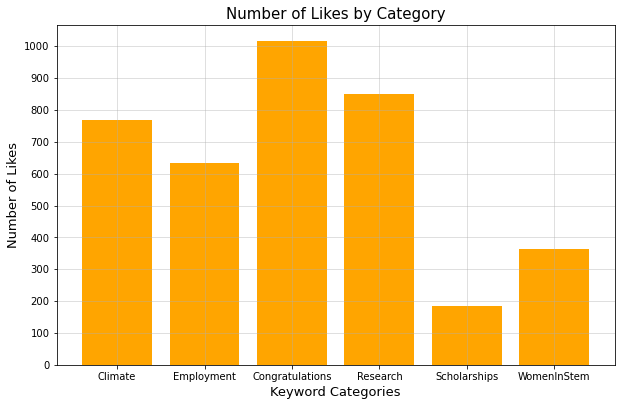

In [7]:
#-----------------------------
#Creating Models from the data
#------------------------------
#Author: Cortland

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Bar Graph of Categories and Corresponding Likes--------------------------------
xVal = list(sections)             
yVal = cat_likes

plt.figure(figsize=(500/50,500/80))
plt.grid(True, alpha=0.5)
plt.xlabel('Keyword Categories', fontsize=13)
plt.ylabel('Number of Likes', fontsize=13)
plt.title('Number of Likes by Category', fontsize=15)
z=-900
plt.bar(range(len(sections)), yVal, tick_label=xVal, color='orange')
plt.yticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()


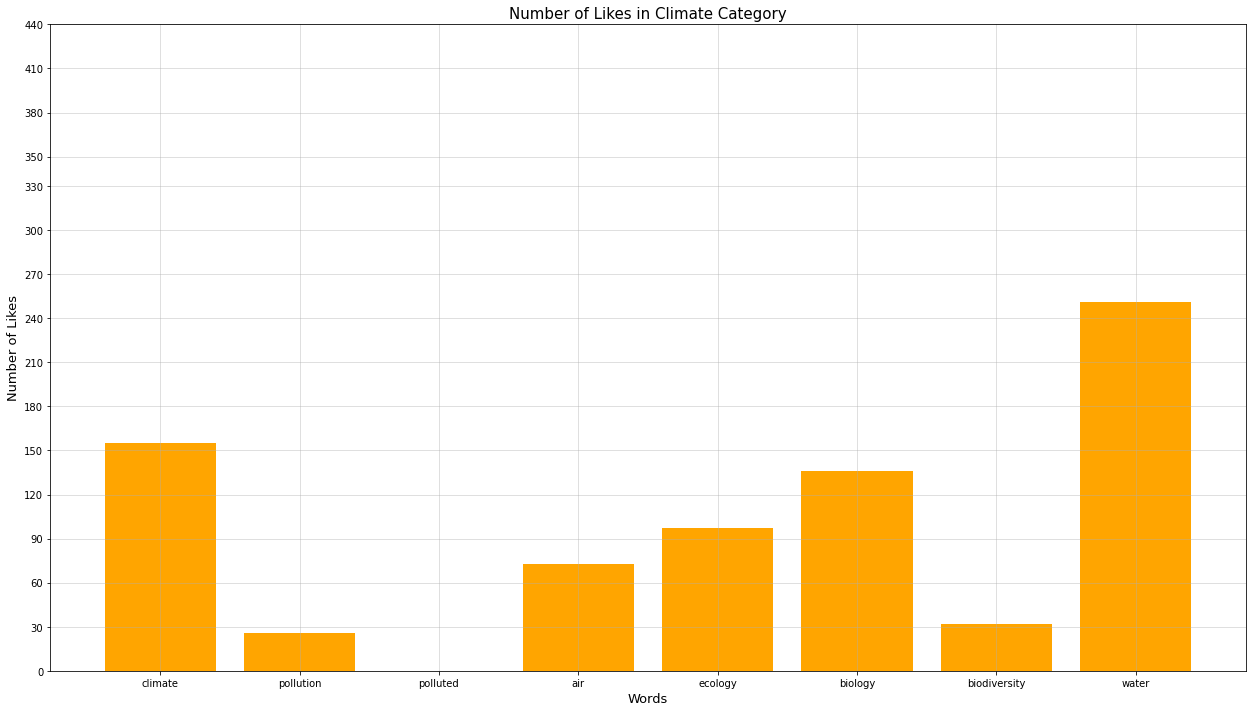

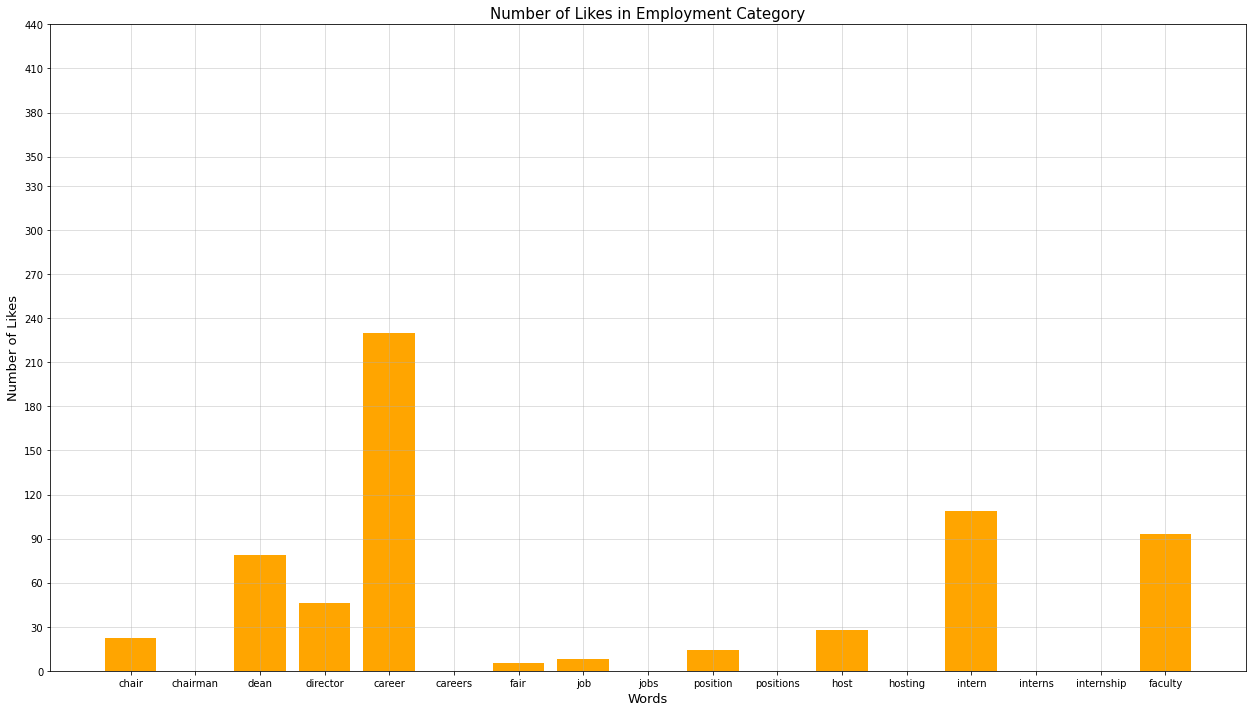

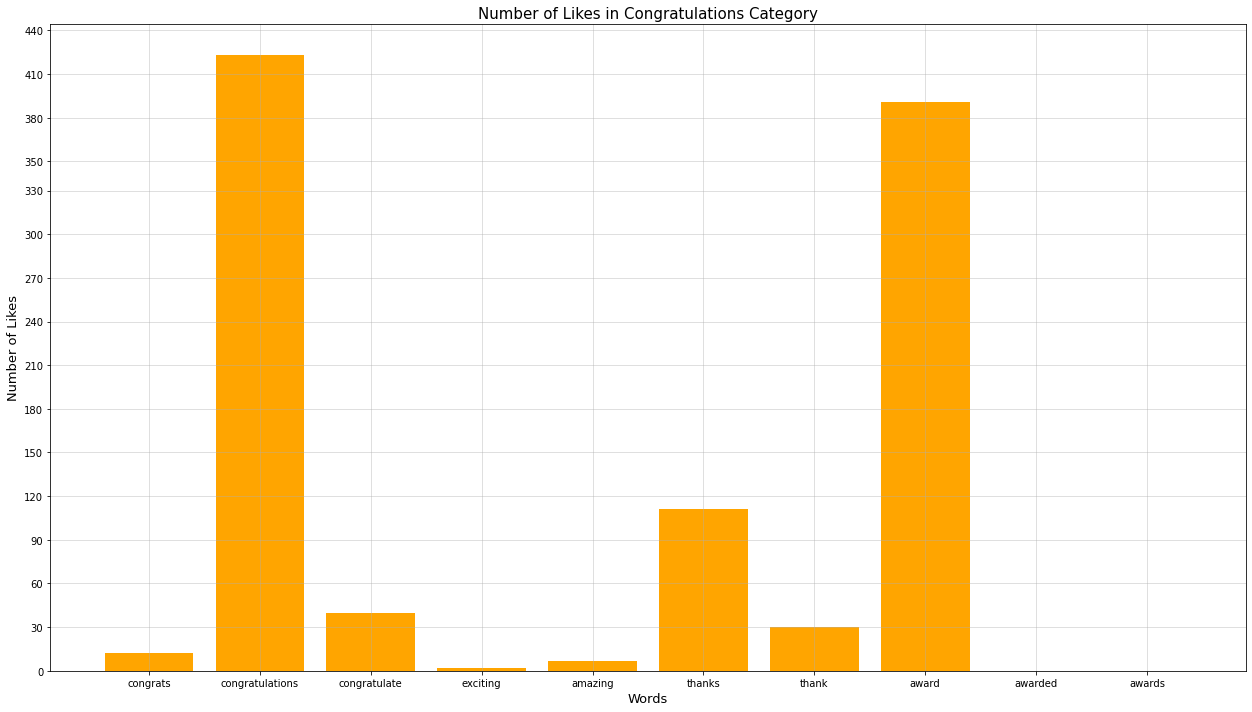

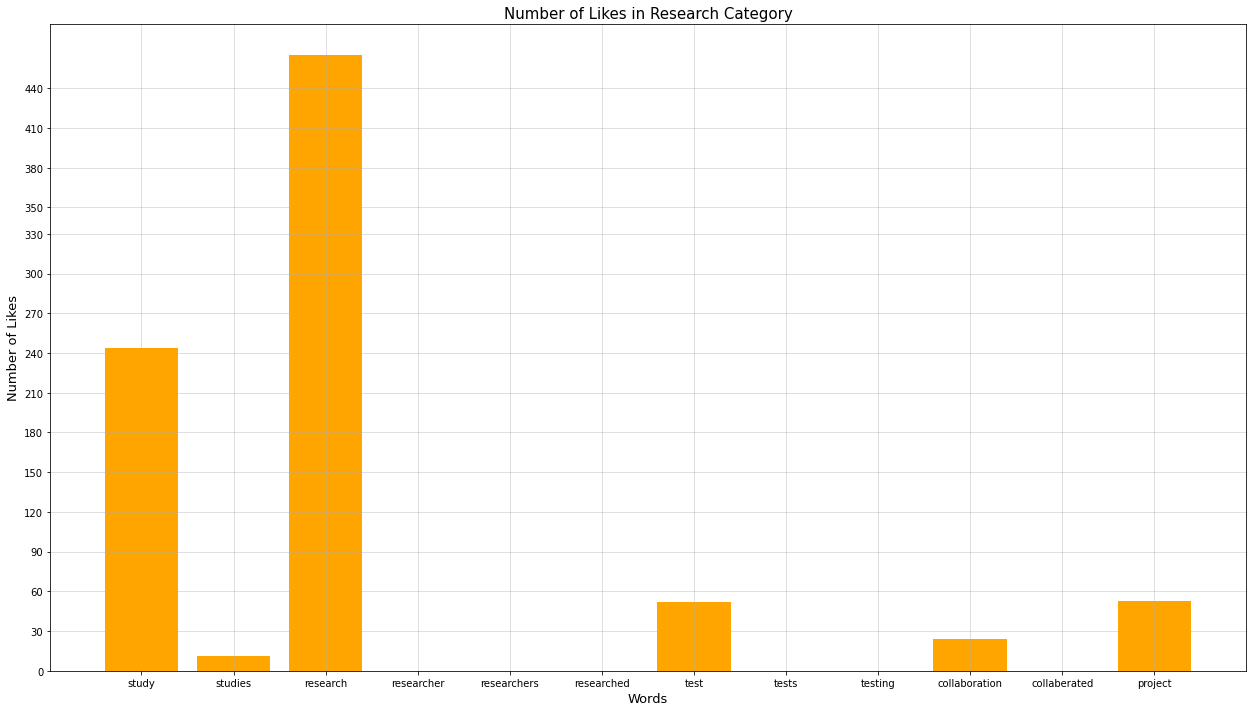

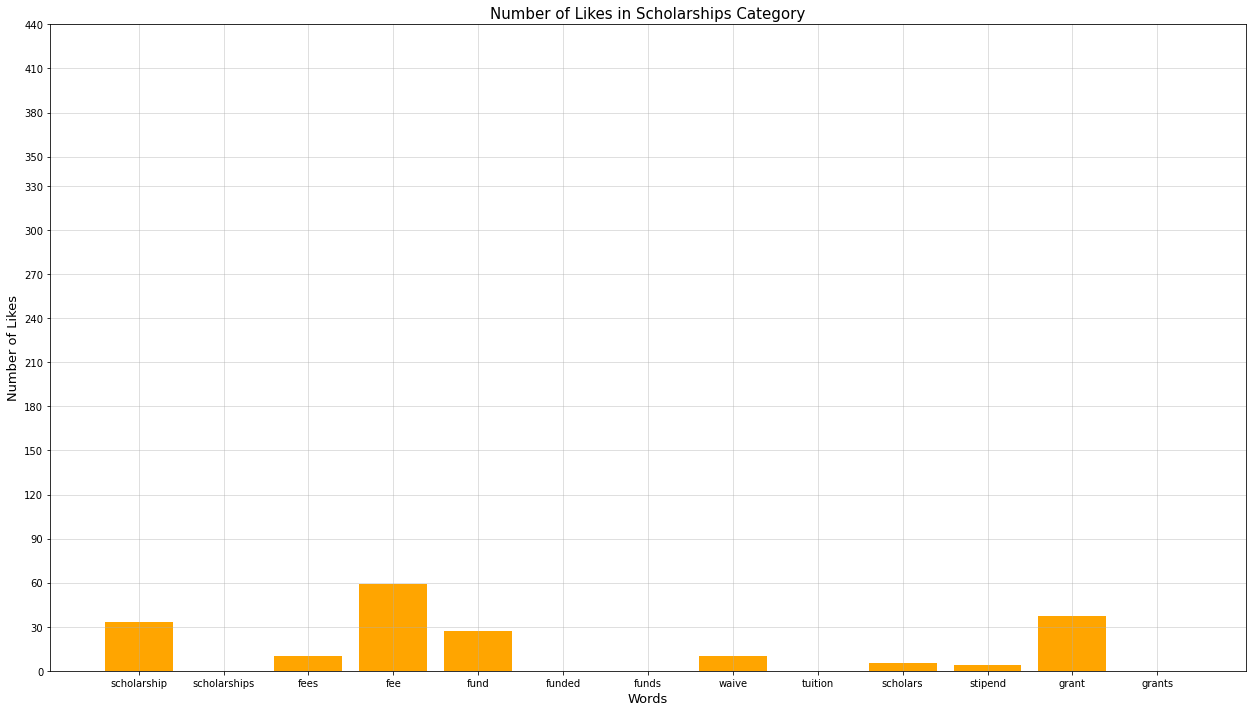

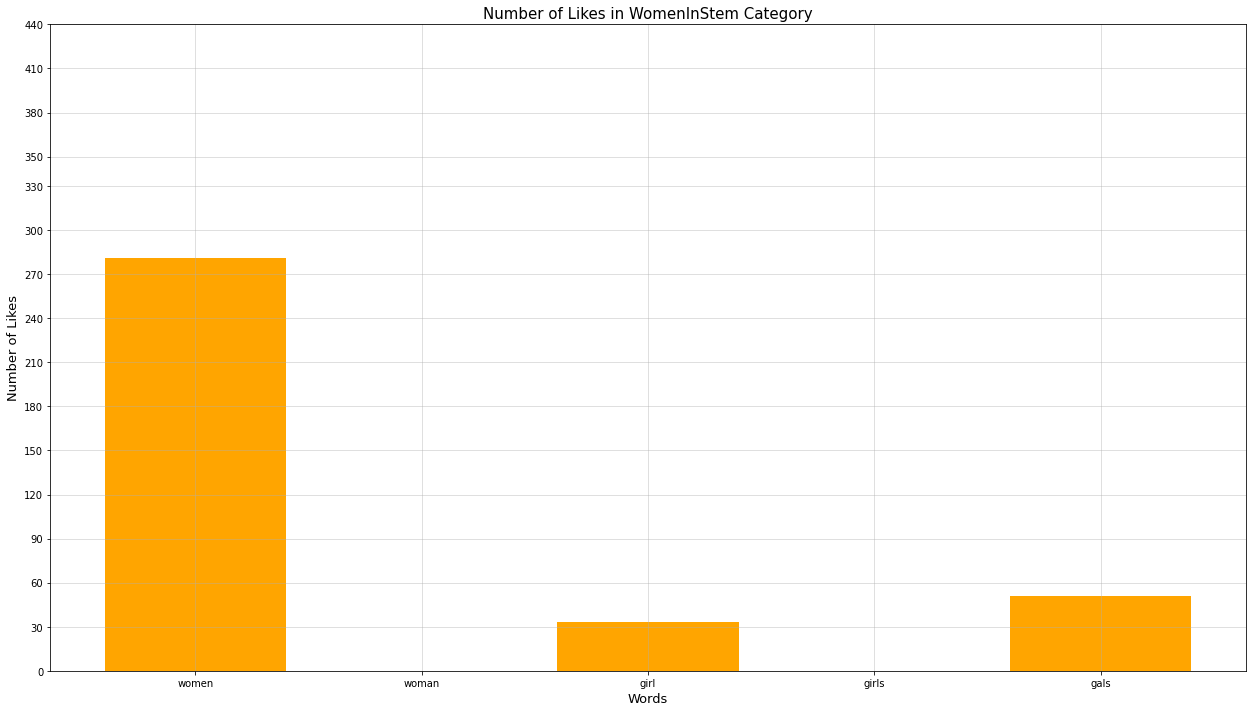

In [8]:
#-------------------------------------------
#Function that takes a file of words and graphs the words with corresponding like counts
#-------------------------------------------
#Author: Cortland

def WordGraphs(filename, section):

    #Creating two lists, 'new_lst' which holds words and 'likes' which holds like counts
    lst = loadFile(filename)

    new_lst = [x[:-1] for x in lst]
    for i in range(len(new_lst)):
        new_lst[i]
    likes = []
    for word in new_lst:
        likes.append(sections[section].words[word].getlikeCount())

    #Plotting the two created lists depending on arguments given to function    
    xVal = new_lst
    yVal = likes
    
    plt.figure(figsize=(700/40,500/50))
    plt.grid(True, alpha=0.5)
    plt.xlabel('Words', fontsize=13)
    plt.ylabel('Number of Likes',fontsize=13)
    plt.title('Number of Likes in '+section+' Category',fontsize=15)
    
    plt.bar(xVal, yVal, tick_label=xVal, color='orange')
    plt.yticks([0,30,60,90,120,150,180,210,240,270,300,330,350,380,410,440])
    plt.tight_layout()
    
    plt.show()

WordGraphs('climate.txt', 'Climate')
WordGraphs('employment.txt', 'Employment')
WordGraphs('congratulations.txt', 'Congratulations')
WordGraphs('research.txt', 'Research')
WordGraphs('scholarships.txt', 'Scholarships')
WordGraphs('women_in_stem.txt', 'WomenInStem')

In [9]:
#-------------------------------------------
#Creating separate categories for the Master list and the Top 10 Words List
#-------------------------------------------
#Author: Cortland

#Reusing some code from above but tweaking the categories so the data isn't muddled by the Master and Top 10 list above
masterSec = buildSecs(['Master', 'TopWords'])

masterSec = buildWords(['master.txt', 'topwords.txt'], masterSec)

for i in range(1, len(t)):
    t2 = t[i].split(',')
    t3 = t2[1].lower().split()

    for word in t3:

        for key in masterSec:
            wl = masterSec[key].getWords()

            for value in wl:

                if value in word:
                    masterSec[key].words[value].setlikeCount(int(t2[2]))
                    masterSec[key].incLikes(int(t2[2]))
                    break

for s in masterSec:
    print(s, ': ', masterSec[s].gettotalLikes(), sep='')

Master: 3792
TopWords: 2687


In [10]:
#----------------------------------------------------------
#Finding the top 10 liked words
#----------------------------------------------------------
#Author: Cortland

def FindMax():
    #This function will create a dictionary with all words and all likes, and then write the top values to a file
    lst = loadFile('master.txt')

    new_lst = [x[:-1] for x in lst]
    for i in range(len(new_lst)):
        new_lst[i]
    likes = []
    for word in new_lst:
        likes.append(masterSec['Master'].words[word].getlikeCount())
    
    #Creating a master dictionary with all words and all corresponding likes
    masterDict = {} 
    for i in new_lst:
        for j in likes:
            masterDict[i] = j
            likes.remove(j)
            break
    print(str(masterDict))
    #Creating a list of the top 10 liked words and then writing them to a file
    top10_val = sorted(masterDict, key=masterDict.get, reverse=True)[:10]
    
    with open('topwords.txt', 'w') as f:
        for w in top10_val:
            f.write('%s\n' % w)
    
FindMax()

{'climate': 155, 'pollution': 26, 'polluted': 0, 'air': 73, 'ecology': 97, 'biology': 136, 'biodiversity': 32, 'water': 251, 'women': 281, 'woman': 0, 'girl': 33, 'girls': 0, 'gals': 51, 'scholarship': 33, 'scholarships': 0, 'fees': 10, 'fee': 59, 'fund': 27, 'funded': 0, 'funds': 0, 'waive': 10, 'tuition': 0, 'scholars': 5, 'stipend': 4, 'grant': 37, 'grants': 0, 'study': 244, 'studies': 11, 'research': 465, 'researcher': 0, 'researchers': 0, 'researched': 0, 'test': 52, 'tests': 0, 'testing': 0, 'collaboration': 24, 'collaberated': 0, 'project': 53, 'congrats': 12, 'congratulations': 423, 'congratulate': 40, 'exciting': 2, 'amazing': 7, 'thanks': 111, 'thank': 30, 'award': 391, 'awarded': 0, 'awardschair': 0, 'chairman': 0, 'dean': 79, 'director': 46, 'career': 230, 'careers': 0, 'fair': 0, 'job': 8, 'jobs': 0, 'position': 14, 'positions': 0, 'host': 28, 'hosting': 0, 'intern': 109, 'interns': 0, 'internship': 0, 'facult': 93}


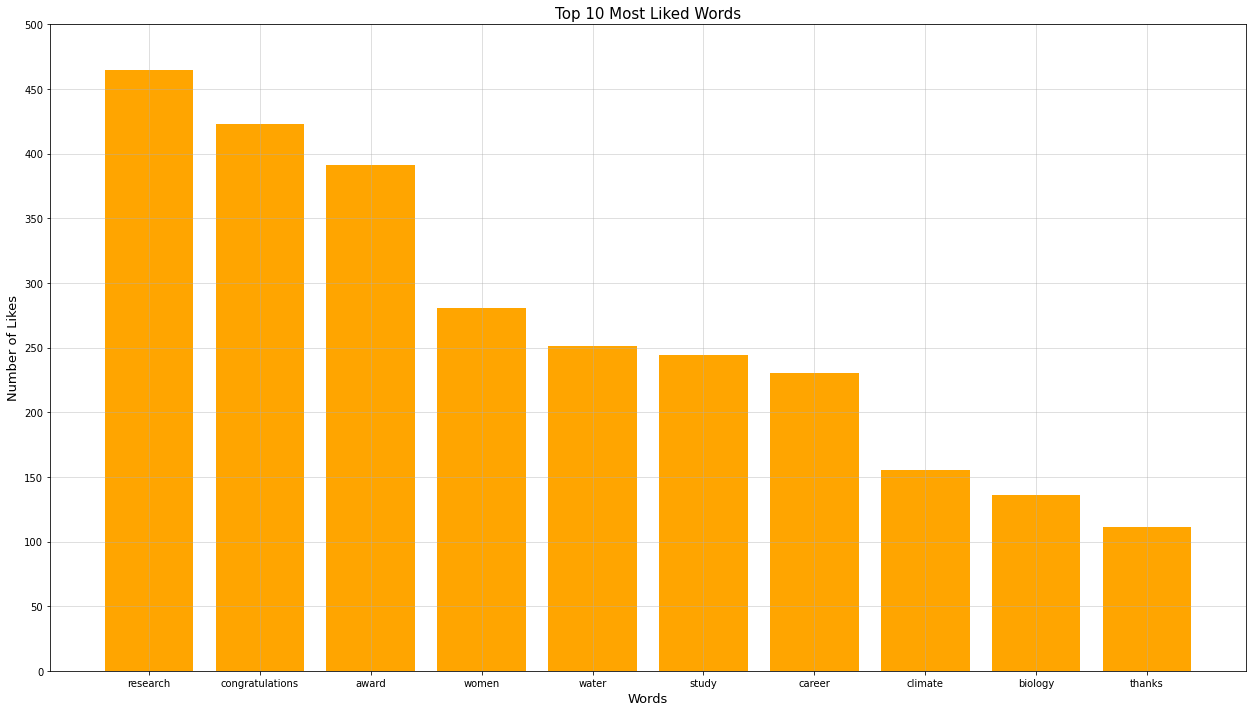

In [11]:
#---------------------------------------------
#Graphing the top 10 most liked words
#---------------------------------------------
#Author: Cortland

def TopGraph(filename, section):
    #Doing the same thing as WordGraphs() but for the Top 10 List
    lst = loadFile(filename)

    new_lst = [x[:-1] for x in lst]
    for i in range(len(new_lst)):
        new_lst[i]
    likes = []
    for word in new_lst:
        likes.append(masterSec[section].words[word].getlikeCount())

   
    xVal = new_lst
    yVal = likes
    
    plt.figure(figsize=(700/40,500/50))
    plt.grid(True, alpha=0.5)
    plt.xlabel('Words', fontsize=13)
    plt.ylabel('Number of Likes',fontsize=13)
    plt.title('Top 10 Most Liked Words',fontsize=15)
    
    plt.bar(xVal, yVal, tick_label=xVal, color='orange')
    plt.yticks([0,50,100,150,200,250,300,350,400,450,500])
    plt.tight_layout()
    
    plt.show()
    
TopGraph('topwords.txt', 'TopWords')

## Creating a Word Cloud

To better visualize the occurrance of words and frequency of likes associated to tweets with such words, we created a word cloud, essentially a mass of words that scales a word based on frequency, thereby showing an image of different words at different scaled sizes.

Top word and likes: research 466


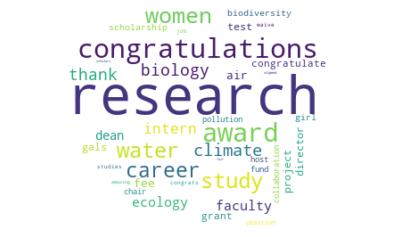

In [4]:
# ---------------------
# Creating a Word Cloud
# ---------------------
# Author: Jake

import matplotlib.pyplot as plt
import wordcloud as wc
import numpy as np
import random
from PIL import Image

"""
Theory: To make this code work for our purposes, we'll need to 
create a string of the words found in each category and append 
each word by the number of times it occurs.

x Goal: Generate graph by frequency of words in all categories.
  Goal: Generate graph by likes for a word in all categories.
  Ex. Goal: Use different images for word clouds.

"""

string = ''
max_likes = 0
top_word = ''
for x in sections:
    for xx in sections[x].getWords():
        n = sections[x].words[xx].getlikeCount()
        string += (xx+' ')*n
        if (n > max_likes):
            max_likes = n
            top_word = xx
print('Top word and likes:', top_word, max_likes)

def word_cloud(string, filename='oldman.jpg'):
    """
    Input:  A string and an image file you would like to use. Please use a file that ends in .jpg.
    Output: Wordcloud graph
    """
    cloud = wc.WordCloud(max_font_size=100, 
                        collocations=False,
                        mask=np.array(Image.open(filename)),
                        background_color='white').generate(string)
    plt.figure(figsize=(500/72,500/72))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

word_cloud(string, filename='lxu.jpg') # Display word cloud


## Additional Studies

Insert cleverly-worded text here.

In [ ]:
# -------------------
# Retrieve dictionary
# -------------------

